## Linear Regression Modelling

The linear regression model is a comparatively simple, yet sophisticated algorithm that can be used for predicting continuous target variables. Because it is not as powerful as the other two models used in the project, the linear regression will serve as a baseline model against which the other two models' results will be compared.

The following evaluation metrics are used to assess the model's performance:

* R-squared
* Mean Absolute Percentage Error (MAPE)

The reasoning behind their selection is described in the notebook with the CatBoost model.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sktime.transformations.series.summarize import WindowSummarizer

In [2]:
%run Function_scripts/functions_model.py
%run Function_scripts/functions_vis.py

In [3]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [4]:
d = pd.read_csv("data/train_df.csv", parse_dates=[0])
d_test = pd.read_csv("data/test_df.csv", parse_dates = [0])

In [5]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

## Modelling 
#### Selecting and defining features 

The following features were selected to be included in the baseline model:

* Item Category
* Store
* Weather 
    * Temperature
    * Precipitation
    * Sunshine duration
* Time variables:
    * Timestep (number of days since the first recorded sale)
    * Day of the year
    * Weekday
    * Week of the year 
    * Month
    * Year
* Window variables
    * Lagged features
    * Rolling averages
    * Rolling standard deviation
* Special events 
    * New Year's Eve
    * Halloween
    * Valentine's Day
* Public Space dummy variable
* Public holidays
* Street market dummy variable

</br>

 Because the variable "school holidays" does not seem to significantly impact sales  (see p-values in the Visualisation notebook), it was not included as a predictor. All the other variables are likely to influence sales to a certain degree. For more information, please refer to the Visualisation notebook.

In [6]:
date = ["date"]

numfeat =["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

catfeat = ["store_name","item_category", 'day', 'halloween', 'hol_pub', 'month', 'nye', 'public_space', 'street_market', 'valentines_day','week_year', 'weekday', 'year']

In [7]:
d2 = d[date + catfeat + numfeat + ["total_amount"]]
d_test2 = d_test[date + catfeat + numfeat + ["total_amount"]]

In [8]:
agg_columns = d2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

d2 = d2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d2["hol_pub"] = d2["hol_pub"].apply(np.int64)

d2 = d2.set_index(["store_name","item_category","date"]).sort_index()

d_test2 = d_test2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d_test2["hol_pub"] = d_test2["hol_pub"].apply(np.int64)

d_test2 = d_test2.set_index(["store_name","item_category","date"]).sort_index()

In [9]:
kwargs = {"lag_feature": {
    "lag":[1,2,3],
    "mean": [[1,7], [1, 15], [1,30]],
    "std": [[1,4]]
    },
    "target_cols":["total_amount"]}

transformer = WindowSummarizer(**kwargs, n_jobs= -1)

In [10]:
d2wind = transformer.fit_transform(d2)
d2wind = pd.concat([d2["total_amount"], d2wind], axis = 1).dropna()

### Transforming features

In order for the linear regression model to work properly, some additional feature preprocessing is necessary. This includes the following transformations of the variables:

* Scaling numerical variables, including window variables
* Adding polynomial features (i.e. squaring and interactions of numerical features, excluding window variables)
* One-hot-encoding of categorical features
* Log transforming the target variable

In [11]:
num_tr =Pipeline(
  steps=[
    ("scaling", RobustScaler()),
    ("polyint",PolynomialFeatures(3,include_bias=False))
])

In [12]:
cat_tr =Pipeline(steps=[
  ("ohe", OneHotEncoder(drop='first',sparse_output=False))
])

In [62]:
wind_tr =Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(func=np.log1p, inverse_func=np.expm1)),
        ("scaling", RobustScaler())
        ]
)

In [65]:
prepro =ColumnTransformer(
  transformers=[
    ("num", num_tr, numfeat),
    ("cat",cat_tr,catfeat),
    ("wind_tr", wind_tr,['total_amount_lag_1', 'total_amount_lag_2',
       'total_amount_lag_3', 'total_amount_mean_1_7', 'total_amount_mean_1_15',
       'total_amount_mean_1_30', 'total_amount_std_1_4'])
])

#### Log transformation of the target variable
The histograms below show the distribution of total daily sales of one store, both as actual and log-transformed values. The log-transformed histogram looks more normally distributed.

The target variable (donut sales) is therefore log transformed so the model can make more accurate predictions. During the prediction step, *sales* are forecasted in the log scale and then transformed back using exponentiation. 

Text(0.5, 0, '')

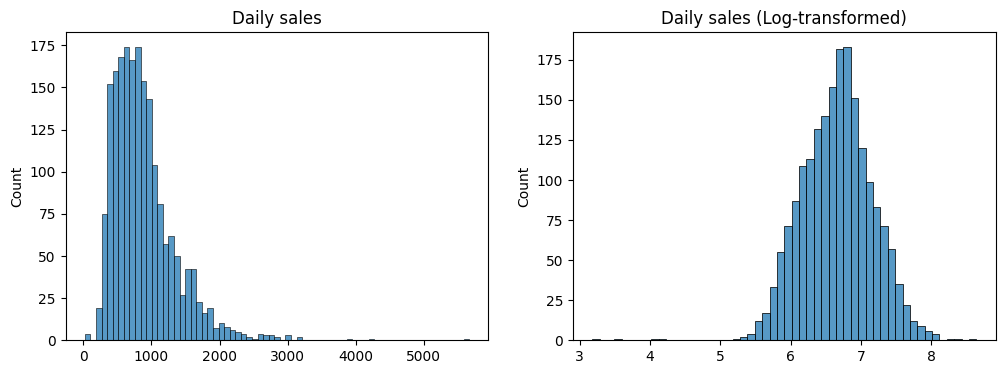

In [109]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

sns.histplot(data = train[(train["store_name"] == "Maybachufer") & (train["item_category"] == "daily total")]["total_amount"], ax = ax[0])
ax[0].set_title("Daily sales")
ax[0].set_xlabel("")

sns.histplot(data = np.log1p(train[(train["store_name"] == "Maybachufer") & (train["item_category"] == "daily total")]["total_amount"]), ax = ax[1])
ax[1].set_title("Daily sales (Log-transformed)")
ax[1].set_xlabel("")

In [66]:
transf_y = Pipeline(
    steps = [
    ("log_transf", FunctionTransformer(func=np.log1p, inverse_func=np.expm1))
    ]
)

In [67]:
lr =Pipeline(
  steps=[
    ("prepro", prepro),
    ("lr",LinearRegression())])

In [68]:
linear_model_transf = TransformedTargetRegressor(regressor= lr, transformer = transf_y)

### Model fit and prediction

In [70]:
train = d2wind.sample(frac=1, random_state=21).iloc[d2wind.index.get_level_values("date") >= pd.to_datetime("2021-07-12")].reset_index().set_index("date")

In [71]:
xtrain = train.reset_index().drop("total_amount", axis = 1).set_index("date")
ytrain = train.reset_index()[["date","total_amount"]].set_index("date")

In [81]:
linear_model_transf.fit(xtrain,ytrain)

TransformedTargetRegressor(regressor=Pipeline(steps=[('prepro',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('scaling',
                                                                                                        RobustScaler()),
                                                                                                       ('polyint',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False))]),
                                                                                       ['days_back',
                                                                                        'temperature_2m_mean',
                                                                                        'sunshine_duration',
                                                                                        'precipitation_hours']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('ohe',
                                                                                                        OneHotEncoder(drop='first',
                                                                                                                      sparse_...
                                                                                                                            inverse_func=<ufunc 'expm1'>)),
                                                                                                       ('scaling',
                                                                                                        RobustScaler())]),
                                                                                       ['total_amount_lag_1',
                                                                                        'total_amount_lag_2',
                                                                                        'total_amount_lag_3',
                                                                                        'total_amount_mean_1_7',
                                                                                        'total_amount_mean_1_15',
                                                                                        'total_amount_mean_1_30',
                                                                                        'total_amount_std_1_4'])])),
                                                     ('lr',
                                                      LinearRegression())]),
                           transformer=Pipeline(steps=[('log_transf',
                                                        FunctionTransformer(func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>))]))

In [87]:
ytrainpred = linear_model_transf.predict(xtrain)

### Evaluating model with test data<br>

The first baseline predictions are made on the test dataset.

In [110]:
train_final = d2wind.iloc[d2wind.index.get_level_values("date") >= pd.to_datetime("2021-07-12")].reset_index().set_index("date")

xtest = d_test2.reset_index().set_index("date").drop("total_amount", axis = 1)
ytest = d_test2.reset_index()[["date","total_amount"]].set_index("date")

In [ ]:
xtest_final, ytestpred = pred_test(train = train_final, test = xtest, model = linear_model_transf)

### Fit statistics for train and test dataset

In [112]:
fit_overview(ytrain, ytrainpred, ytest, ytestpred)

R-squared train:  0.92
Mean absolute percentage error train:  26.0 

R-squared test  0.898
Mean absolute percentage error test:  26.0


For a baseline model, the final test results of the linear regression are relatively good. The **R-squared value of 0.9** is quite high for the test dataset. The **Mean Absolute Percentage Error (MAPE) of 26%** means that the model's predictions are, on average, 26% over or under the actual sales. The results can be further broken down into MAPE scores at the store and product category level.

In [90]:
mape_stores(d_test2, ytestpred, breakdown = "stores").sort_values("MAPE").reset_index(drop = True)

,Store name,MAPE
0,Jungfernstieg,[20.41255593230894]
1,Potsdamer,[21.340530140355074]
2,Neuer Kamp,[22.105932162432072]
3,Danziger,[23.036180544060255]
4,Mitte,[24.520883628633552]
5,Maybachufer,[25.94572683928529]
6,Warschauer,[30.493432624799645]
7,Altona,[37.26600070210256]


In [91]:
mape_stores(d_test2, ytestpred, breakdown = "stores_products").sort_values("MAPE").reset_index(drop = True)

,Store name,Product Category,MAPE
0,Altona,monthly_specials,[13.598857473097622]
1,Maybachufer,monthly_specials,[15.283161720350263]
2,Jungfernstieg,monthly_specials,[16.146499326368893]
3,Jungfernstieg,daily total,[16.395479279337188]
4,Mitte,monthly_specials,[16.457307949655057]
5,Potsdamer,monthly_specials,[18.038130538519273]
6,Neuer Kamp,monthly_specials,[18.280382458175662]
7,Potsdamer,classics,[18.368274261502446]
8,Maybachufer,daily total,[18.96270568608131]
9,Potsdamer,daily total,[19.29712567076772]


While some stores and store-product combinations were predicted relatively well and their MAPE scores are low, other stores and products don't exhibit such good results. Still, for a baseline model, the forecasted sales are solid, but can certainly be improved upon. This is especially true for those store-product combinations with a MAPE of over 30%.

Other models, especially tree-based methods, can be leveraged to improve upon the baseline model's predictions. This is further explored in the Random Forests and CatBoost notebooks.